<img src="40種人臉.png" style="width:1200px;height:634px;float:middle">
<br><br>

<img src="測試結果.png" style="width:1200px;height:541px;float:middle">
<br><br>

<img src="siamese_network.png" style="width:238px;height:150px;float:middle">
以上為siamese network的計算流程<br>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator
import re
import matplotlib.pyplot as plt
import skimage.transform
import math

Using TensorFlow backend.


In [2]:
def read_image(filename , byteorder = '>'):
    
    # 1. we read the image, as a raw file to the buffer
    f = open(filename , 'rb')
    buffer = f.read()
    
    # 2. using regex, we extract the header, width, height and maxval of the image
    header , width , height , maxval =\
    re.search(b"(^P5\s(?:\s*#.*[\r\n])*"
              b"(\d+)\s(?:\s*#.*[\r\n])*"
              b"(\d+)\s(?:\s*#.*[\r\n])*"
              b"(\d+)\s(?:\s*#.*[\r\n]\s)*)" , buffer).groups()

    # 3. we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    image = np.frombuffer(buffer ,
                          dtype = 'u1' if int(maxval) < 256 else byteorder + 'u2' ,
                          count = int(width) * int(height),
                          offset = len(header))
    image = image.reshape([int(height) , int(width)])

    return image

In [3]:
size = 2
image = read_image('data/face_{}/{}.pgm'.format(1 , 1))
# 取影像一半的維度，能加快運算速度，又不至於失去影像的特徵
image = image[::size , ::size]
dim1 = image.shape[0] 
dim2 = image.shape[1]

In [4]:
def get_batch(size , total_sample_size , dim1 , dim2 , train = True , num = 7):
    # 取相同類別的人臉影像
    count = 0
    x_similar_image_resize = np.zeros([total_sample_size , 2 , dim1 , dim2 , 1])
    x_similar_image = np.zeros([total_sample_size , 2 , int(dim1*2) , int(dim2*2) , 1])
    y_similar = np.zeros([total_sample_size])
    for i in range(0 , 39):
        for j in range(int(total_sample_size / 40)):
            index_1 = 0
            index_2 = 0
            while index_1 == index_2:
                # 取每種人臉類別資料夾中 1~num 張人臉影像當作訓練影像
                if train:
                    index_1 = np.random.randint(num)
                    index_2 = np.random.randint(num)
                # 取每種人臉類別資料夾中 取 num~10 張人臉影像當作訓練影像
                else:
                    index_1 = np.random.randint(num , 10)
                    index_2 = np.random.randint(num , 10)

            img1 = read_image('data/face_{}/{}.pgm'.format(i + 1 , index_1 + 1))
            img2 = read_image('data/face_{}/{}.pgm'.format(i + 1 , index_2 + 1))

            x_similar_image[count , 0 , : , : , 0] = img1
            x_similar_image[count , 1 , : , : , 0] = img2

            # img1 = skimage.transform.resize(img1 , [dim1 , dim2 , 1])
            # img2 = skimage.transform.resize(img2 , [dim1 , dim2 , 1])
            # 這種resize的方式可以加快運算速度
            img1_resize = img1[::size , ::size]
            img2_resize = img2[::size , ::size]
            
            x_similar_image_resize[count , 0 , : , : , 0] = img1_resize
            x_similar_image_resize[count , 1 , : , : , 0] = img2_resize
            
            y_similar[count] = 1
            count += 1

    # 取不同類別的人臉            
    count = 0
    x_dissimilar_image_resize = np.zeros([total_sample_size , 2 , dim1 , dim2 ,  1])
    x_dissimilar_image = np.zeros([total_sample_size , 2 , int(dim1*2) , int(dim2*2) , 1])
    y_dissimilar = np.zeros([total_sample_size])
    for i in range(0 , int(total_sample_size)):

        while True:
            index_1 = np.random.randint(40)
            index_2 = np.random.randint(40)
            if index_1 != index_2:
                break
        
        # 取每種人臉類別資料夾中 1~num 張人臉影像當作訓練影像
        if train:
            index_1_ = np.random.randint(num)
            index_2_ = np.random.randint(num)
        # 取每種人臉類別資料夾中 取 num~10 張人臉影像當作訓練影像
        else:
            index_1_ = np.random.randint(num , 10)
            index_2_ = np.random.randint(num , 10)

        img1 = read_image('data/face_{}/{}.pgm'.format(index_1 + 1 , index_1_ + 1))
        img2 = read_image('data/face_{}/{}.pgm'.format(index_2 + 1 , index_2_ + 1))

        x_dissimilar_image[count , 0 , : , : , 0] = img1
        x_dissimilar_image[count , 1 , : , : , 0] = img2

        # img1 = skimage.transform.resize(img1 , [dim1 , dim2 , 1])
        # img2 = skimage.transform.resize(img2 , [dim1 , dim2 , 1])
        # 這種resize的方式可以加快運算速度
        img1_resize = img1[::size , ::size]
        img2_resize = img2[::size , ::size]

        x_dissimilar_image_resize[count , 0 , : , : , 0] = img1_resize
        x_dissimilar_image_resize[count , 1 , : , : , 0] = img2_resize
        y_dissimilar[count] = 0
        count += 1
            
    x_resize = np.concatenate([x_similar_image_resize , x_dissimilar_image_resize] , axis = 0) / 255
    x = np.concatenate([x_similar_image_resize , x_dissimilar_image_resize] , axis = 0)
    y = np.concatenate([y_similar , y_dissimilar] , axis = 0)

    return x_resize , y , x

In [5]:
def feature_extractor(input_ , reuse = False):
    if reuse : tf.get_variable_scope().reuse_variables()
    with tf.variable_scope('conv1'):
        conv_output_1 = tf.contrib.layers.conv2d(input_ , 6 , [3 , 3] ,
                                                 activation_fn = tf.nn.relu , padding = 'VALID' ,
                                                 weights_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        conv_pooling_1 = tf.contrib.layers.max_pool2d(conv_output_1 , [2 , 2] , padding = 'VALID')
        conv_dropout_1 = tf.cond(on_train ,
                                 lambda : tf.nn.dropout(conv_pooling_1 , keep_prob = 0.8) ,
                                 lambda : tf.nn.dropout(conv_pooling_1 , keep_prob = 1))

    with tf.variable_scope('conv2'):
        conv_output_2 = tf.contrib.layers.conv2d(conv_dropout_1  , 12 , [3 , 3] ,
                                                 activation_fn = tf.nn.relu , padding = 'VALID' ,
                                                 weights_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        conv_pooling_2 = tf.contrib.layers.max_pool2d(conv_output_2 , [2 , 2] , padding = 'VALID')
        conv_dropout_2 = tf.cond(on_train ,
                                 lambda : tf.nn.dropout(conv_pooling_2 , keep_prob = 0.8) ,
                                 lambda : tf.nn.dropout(conv_pooling_2 , keep_prob = 1))

    with tf.variable_scope('flatten'):
        output_flatten_1 = tf.contrib.layers.flatten(conv_dropout_2)
        output_flatten_1 = tf.layers.dense(output_flatten_1 , 128 ,
                                            activation = tf.nn.relu ,
                                            kernel_initializer = tf.contrib.layers.xavier_initializer())
        output_flatten_1 = tf.cond(on_train ,
                                   lambda : tf.nn.dropout(output_flatten_1 , keep_prob = 0.9) ,
                                   lambda : tf.nn.dropout(output_flatten_1 , keep_prob = 1))
        output_flatten_2 = tf.layers.dense(output_flatten_1 , 64 ,
                                           activation = tf.nn.relu)

    return output_flatten_2

In [6]:
input_image = tf.placeholder(tf.float32 , [None , 2 , dim1 , dim2 , 1])
x_a = input_image[: , 0 , : , : , :]
x_b = input_image[: , 1 , : , : , :]
y_true = tf.placeholder(tf.float32 , [None])
on_train = tf.placeholder(tf.bool)


with tf.variable_scope('feature_extractor'):
    embedding_a = feature_extractor(x_a , reuse = False)
    embedding_b = feature_extractor(x_b , reuse = True)


with tf.variable_scope('euclidean_distance'):
    distance = tf.reduce_sum(tf.pow(embedding_a - embedding_b , 2) , axis = 1)
    distance = tf.sqrt(tf.maximum(distance , 1e-9))


with tf.variable_scope('contrastive_loss'):
    margin = 2
    similarity = tf.multiply(y_true , tf.square(distance))
    dissimilarity = tf.multiply(1 - y_true, tf.square(tf.maximum(margin - distance , 0)))
    contrastive_loss = tf.reduce_mean(similarity + dissimilarity)

    
with tf.variable_scope('accuracy'):
    correct = tf.equal(tf.cast(distance < margin / 2 , tf.int32) , tf.cast(y_true , tf.int32))
    accuracy = tf.reduce_mean(tf.cast(correct , tf.float32))

    
with tf.variable_scope('optimizer'):
    train_op = tf.train.AdamOptimizer(1e-3).minimize(contrastive_loss)

In [7]:
def batch_generator(X , y , batch_size):
    size = X.shape[0]
    X_copy = X.copy()
    y_copy = y.copy()
    indices = np.arange(size)
    np.random.shuffle(indices)
    X_copy = X_copy[indices]
    y_copy = y_copy[indices]
    i = 0
    while True:
        if i + batch_size <= size:
            yield X_copy[i : i + batch_size] , y_copy[i : i + batch_size]
            i += batch_size
        else:
            i = 0
            indices = np.arange(size)
            np.random.shuffle(indices)
            X_copy = X_copy[indices]
            y_copy = y_copy[indices]


# 數據增強
aug = ImageDataGenerator(rotation_range = 25, 
                         width_shift_range = 0.1,
                         height_shift_range = 0.1 ,
                         shear_range = 0.2 ,
                         zoom_range = 0.2,
                         horizontal_flip = True ,
                         fill_mode = 'nearest')


# 可在餵資料進NN訓練前，決定要不要做數據增強
def augmentation(x_train , aug_data = True):
    if aug_data:
        x_train_1 = aug.flow(x_train[: , 0] ,
                             np.arange(128) ,
                             shuffle = False ,
                             batch_size = batch_size)[0][0]
        x_train_1 = np.expand_dims(x_train_1 , axis = 1)
    
        x_train_2 = aug.flow(x_train[: , 1] ,
                             np.arange(128) ,
                             shuffle = False ,
                             batch_size = batch_size)[0][0]
        x_train_2 = np.expand_dims(x_train_2 , axis = 1)
        return np.concatenate([x_train_1 , x_train_2] , axis = 1)

    else:
        x_train_1 = np.expand_dims(x_train[: , 0] , axis = 1)
        x_train_2 = np.expand_dims(x_train[: , 1]  , axis = 1)
        return np.concatenate([x_train_1 , x_train_2] , axis = 1)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 8
batch_size = 128
x_train , y_train , _ = get_batch(size , 10000 , dim1 , dim2)
num_batch = math.ceil(len(x_train) / batch_size)
for epoch_i in range(0 , epochs):
    x_train , y_train , _ = get_batch(size , 10000 , dim1 , dim2)
    shuffle = np.arange(len(x_train))
    np.random.shuffle(shuffle)
    x_train = x_train[shuffle]
    y_train = y_train[shuffle]
    train_batch_generator = batch_generator(x_train , y_train , batch_size)

    for batch_i in range(0 , num_batch):
        x_train_bathch , y_train_bathch = next(train_batch_generator)

        # 先不做數據增強，加快運算速度
        x_train_bathch_aug = augmentation(x_train_bathch ,
                                          aug_data = False)

        _ , train_loss = sess.run([train_op , contrastive_loss] ,
                                  feed_dict = {input_image : x_train_bathch_aug ,
                                               y_true : y_train_bathch ,
                                               on_train : True})

        if batch_i % 70 == 0:
            print('=' * 30)
            print('epoch : {}'.format(epoch_i))
            print('batch : {}'.format(batch_i))
            print('train_loss : {:.3f}'.format(train_loss))

    # 每一次測試前，都會對影像重新取樣        
    x_test_resize , y_test , x_test = get_batch(2 , 200 , dim1 , dim2 , train = False)
    test_loss , test_acc = sess.run([contrastive_loss , accuracy] ,
                                    feed_dict = {input_image : x_test_resize ,
                                                 y_true : y_test ,
                                                 on_train : False})

    print('*' * 30)
    print('epoch : {}'.format(epoch_i))
    print('test_loss : {:.3f}'.format(test_loss))
    print('test_accuracy : {:.2%}'.format(test_acc))
    print('*' * 30)

epoch : 0
batch : 0
train_loss : 1.033
epoch : 0
batch : 70
train_loss : 0.557
epoch : 0
batch : 140
train_loss : 0.421
******************************
epoch : 0
test_loss : 0.473
test_accuracy : 85.75%
******************************
epoch : 1
batch : 0
train_loss : 0.369
epoch : 1
batch : 70
train_loss : 0.278
epoch : 1
batch : 140
train_loss : 0.339
******************************
epoch : 1
test_loss : 0.360
test_accuracy : 89.00%
******************************
epoch : 2
batch : 0
train_loss : 0.259
epoch : 2
batch : 70
train_loss : 0.158
epoch : 2
batch : 140
train_loss : 0.229
******************************
epoch : 2
test_loss : 0.270
test_accuracy : 92.25%
******************************
epoch : 3
batch : 0
train_loss : 0.180
epoch : 3
batch : 70
train_loss : 0.123
epoch : 3
batch : 140
train_loss : 0.106
******************************
epoch : 3
test_loss : 0.229
test_accuracy : 94.25%
******************************
epoch : 4
batch : 0
train_loss : 0.126
epoch : 4
batch : 70
train_lo

### 觀察人臉辨識系統在測試集地的效果

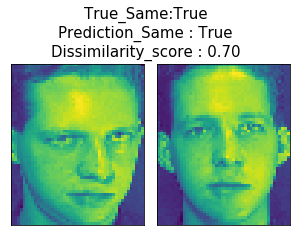

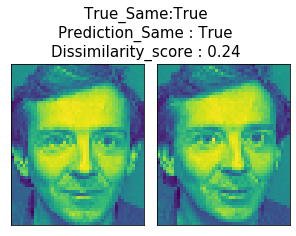

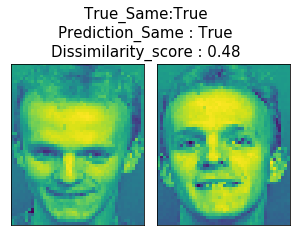

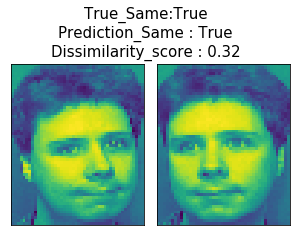

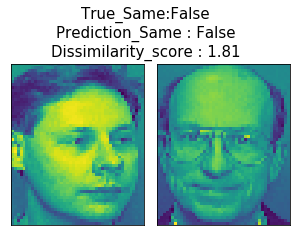

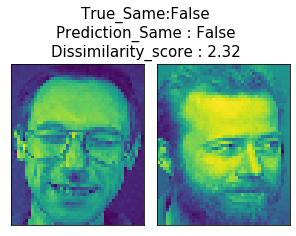

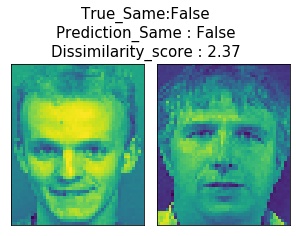

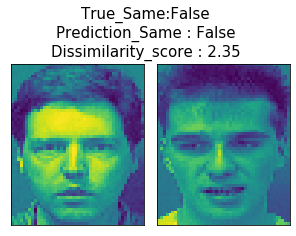

In [9]:
indices = [0 , 10 , 20 , 110 , 220 , 300 , 320 , 390]
for idx in indices:
    x_show = np.concatenate([np.expand_dims(x_test_resize[idx , 0 , : , : , 0] , [0 , 1 , 4]) ,
                             np.expand_dims(x_test_resize[idx , 1 , : , : , 0] , [0 , 1 , 4])],
                             axis = 1)
    dissimilarity_score = sess.run(distance ,
                                   feed_dict = {input_image : x_show ,
                                                on_train : False})

    fig, ax = plt.subplots(1 , 2 , figsize = (5 , 4))
    plt.subplots_adjust(wspace = 0.1 , hspace = 0.4)
    ax[0].imshow(x_test[idx , 0 , : , : , 0])
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].imshow(x_test[idx , 1 , : , : , 0])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    fig.suptitle('True_Same:{}\nPrediction_Same : {}\nDissimilarity_score : {:.2f}'\
                 .format(np.bool(y_test[idx]) , dissimilarity_score[0] < margin / 2 , dissimilarity_score[0]) ,
                  fontsize = 15)

### 觀察人臉辨識系統是否能辨別陌生人臉

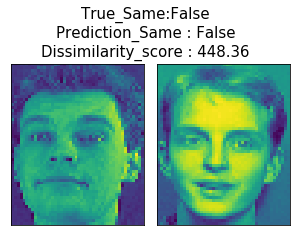

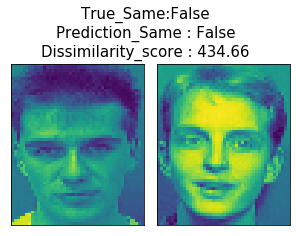

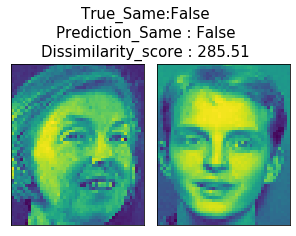

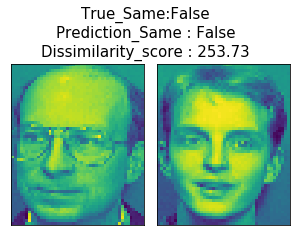

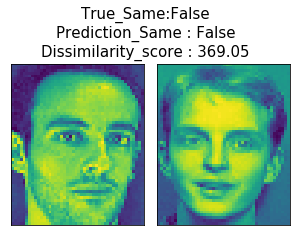

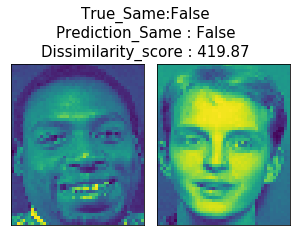

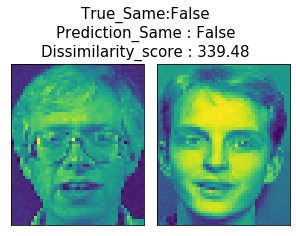

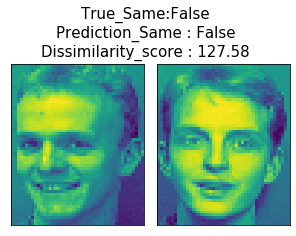

In [10]:
# 隨機從測試集中取6張人臉
staff_image = []
staff_index = np.random.randint(39 , size = 8)
for index in staff_index:
    image = read_image('data/face_{}/{}.pgm'.format(index , 7)) 
    image = image[::size , ::size]
    image = np.expand_dims(image , axis = [0 , -1])
    staff_image.append(image)
staff_image = np.array(staff_image)

# 第40張人臉為陌生人臉
stranger_image = read_image('data/face_{}/{}.pgm'.format(40 , 5))
stranger_image = np.expand_dims(stranger_image[::size , ::size] , axis = [0 , 1 , -1])
stranger_image = np.tile(stranger_image , [8 , 1 , 1 , 1 , 1])

# 將測試集的6張人臉與陌生人臉輸入NN，計算embedding_vector的距離
image_compare_stranger = np.concatenate([staff_image , stranger_image] , axis = 1)
dissimilarity_score = sess.run(distance ,
                               feed_dict = {input_image : image_compare_stranger ,
                                            on_train : False})

for i in range(0 , 8):
    fig, ax = plt.subplots(1 , 2 , figsize = (5 , 4))
    plt.subplots_adjust(wspace = 0.1 , hspace = 0.4)
    ax[0].imshow(image_compare_stranger[i , 0 , : , : , 0])
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].imshow(image_compare_stranger[i , 1 , : , : , 0])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    fig.suptitle('True_Same:{}\nPrediction_Same : {}\nDissimilarity_score : {:.2f}'\
                 .format(False , dissimilarity_score[i] < margin / 2 , dissimilarity_score[i]) ,
                  fontsize = 15) 